# TP53 benchmarking with training cohort data

#### TP53 experimental assay from Ursu O, Neal JT, Shea E, Thakore PI, Jerby-Arnon L, Nguyen L, et al. Massively parallel phenotyping of coding variants in cancer with Perturb-seq. Nat Biotechnol 2022;40:896–905.

### 1. Upload data
### 2. Generate crossvalidation data
### 3. Precision recall curves
### 4. F50 score and performance

# 1. Upload data

In [1]:
import pandas as pd
import numpy as np
import os
from io import StringIO
from scipy.stats import fisher_exact
import copy
import gzip
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 40)
import matplotlib.pyplot as plt
import collections

import matplotlib as mpl
mpl.rcParams['figure.dpi']= 150

In [2]:
TP53_Ursu = pd.read_csv('../../../Paper_data/Experimental_data/TP53/bench_TP53_Ursu.csv', sep='\t')
# Remove last two rows
TP53_Ursu = TP53_Ursu.iloc[:-2,:]
# Remove unavailable cases
TP53_Ursu = TP53_Ursu[~(TP53_Ursu['HotellingT2'].isna())]
TP53_Ursu

,Variant,Gene,Position: base(s),From ORF base(s),To ORF base(s),Position: amino acid(s),From amino acid(s),To amino acid(s),From ORF codon(s),To ORF codon(s),Mutation type,Control status,Variant barcode,Library synthesis,Cells/variant,Normalized variant barcode counts (TP10K),HotellingT2,HotellingT2.q,Variant functional class,Count (pancan),Count (ExAC),Count (IARC),"Nutlin-3, TP53 WT growth (z-score)","Nutlin-3, TP53 null growth (z-score)","Etoposide, TP53 null growth (z-score)",Insert sequence
0,R175H,TP53,524,G,A,175.0,R,H,CGC,CAC,Single,unknown,CCTACCAGGAAGAA,in,1001.0,2.103363,365.212625,0.000010,Impactful II,993.0,NaN,1221.0,1.791388,0.538396,-0.744765,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
1,R273C,TP53,817,C,T,273.0,R,C,CGT,TGT,Single,unknown,TCACAAGGCAAGAA,in,1253.0,1.983869,241.672937,0.000010,Impactful I,677.0,NaN,718.0,1.261347,0.314304,-0.930398,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
3,R273H,TP53,818,G,A,273.0,R,H,CGT,CAT,Single,unknown,CACTGAGGCAAGAA,in,835.0,1.820028,169.301582,0.000010,Impactful I,622.0,NaN,863.0,1.145501,1.077844,-1.438387,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
4,R248W,TP53,742,C,T,248.0,R,W,CGG,TGG,Single,unknown,CTGGCGGACAAGAA,in,907.0,1.742191,289.806537,0.000010,Impactful II,550.0,NaN,770.0,1.552718,0.613931,-0.689231,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
5,R282W,TP53,844,C,T,282.0,R,W,CGG,TGG,Single,unknown,ACTTCCGCCAAGAA,in,1506.0,1.963920,274.549952,0.000010,Impactful II,468.0,NaN,617.0,1.590703,0.729156,-0.757142,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,P295P,TP53,885,T,C,295.0,P,P,CCT,CCC,Single,synonymous,TCCACGTCTAAGAA,in,659.0,2.245107,26.879328,0.569579,WT-like,NaN,7.0,NaN,0.110172,0.224554,0.150309,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
96,T118T,TP53,354,A,T,118.0,T,T,ACA,ACT,Single,synonymous,AAGCCGACTAAGAA,in,949.0,2.192555,27.217785,0.565986,WT-like,NaN,6.0,NaN,0.442678,-0.132830,0.209193,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
97,P359P,TP53,1077,A,G,359.0,P,P,CCA,CCG,Single,synonymous,AGACGAGAAGAGAA,in,1048.0,2.412174,25.465182,0.595796,WT-like,NaN,1.0,NaN,-0.169388,-0.614077,0.764566,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...
98,L344L,TP53,1032,G,C,344.0,L,L,CTG,CTC,Single,synonymous,CAGGAAGAAGAGAA,in,918.0,2.280145,30.842084,0.488017,WT-like,NaN,2.0,NaN,0.156622,-0.203451,0.249615,ATGGAGGAGCCGCAGTCAGATCCTAGCGTCGAGCCCCCTCTGAGTC...


In [3]:
# Upload the TP53 boostDM-CH predictions
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'TP53.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
gene_model

,gene,ENSEMBL_TRANSCRIPT,ENSEMBL_GENE,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,selected_model_ttype,boostDM_score,boostDM_class,shap_CLUSTL_SCORE,shap_CLUSTL_cat_1,shap_HotMaps_cat_1,shap_smRegions_cat_1,shap_PhyloP,shap_nmd,shap_Acetylation,shap_Methylation,shap_Phosphorylation,shap_Regulatory_Site,shap_Ubiquitination,shap_csqn_type_missense,shap_csqn_type_nonsense,shap_csqn_type_splicing,shap_csqn_type_synonymous,ID
0,TP53,ENST00000269305,ENSG00000141510,17,7669612,A,D393D,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,CH,0.000906,False,-0.024345,0.0,-2.079028,-0.155365,-0.428166,0.0,0.000016,0.001413,0.003593,0.000654,-0.000315,0.084412,-0.161530,-0.167058,-0.134467,7669612A
1,TP53,ENST00000269305,ENSG00000141510,17,7669612,C,D393E,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000801,False,-0.024866,0.0,-2.167131,-0.112915,-0.444743,0.0,0.000016,0.001717,0.003768,0.000692,-0.000336,-0.053726,-0.161603,-0.165962,0.011377,7669612C
2,TP53,ENST00000269305,ENSG00000141510,17,7669612,T,D393E,0.0,0,0,0,1.981445,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000801,False,-0.024866,0.0,-2.167131,-0.112915,-0.444743,0.0,0.000016,0.001717,0.003768,0.000692,-0.000336,-0.053726,-0.161603,-0.165962,0.011377,7669612T
3,TP53,ENST00000269305,ENSG00000141510,17,7669613,A,D393V,0.0,0,0,0,3.425781,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002309,False,-0.022500,0.0,-1.960687,-0.067766,-0.258042,0.0,0.000019,0.000353,0.003853,0.000693,-0.000351,-0.049602,-0.146028,-0.163720,0.011061,7669613A
4,TP53,ENST00000269305,ENSG00000141510,17,7669613,C,D393G,0.0,0,0,0,3.425781,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.002309,False,-0.022500,0.0,-1.960687,-0.067766,-0.258042,0.0,0.000019,0.000353,0.003853,0.000693,-0.000351,-0.049602,-0.146028,-0.163720,0.011061,7669613C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3523,TP53,ENST00000269305,ENSG00000141510,17,7676590,C,E2G,0.0,0,0,0,1.806641,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000816,False,-0.024763,0.0,-2.191683,-0.115753,-0.410044,0.0,0.000016,0.002003,0.003799,0.000700,-0.000335,-0.053798,-0.161667,-0.165514,0.011389,7676590C
3524,TP53,ENST00000269305,ENSG00000141510,17,7676590,G,E2A,0.0,0,0,0,1.806641,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000816,False,-0.024763,0.0,-2.191683,-0.115753,-0.410044,0.0,0.000016,0.002003,0.003799,0.000700,-0.000335,-0.053798,-0.161667,-0.165514,0.011389,7676590G
3525,TP53,ENST00000269305,ENSG00000141510,17,7676591,A,E2*,0.0,0,0,0,1.867188,0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,CH,0.278992,False,-0.021575,0.0,-1.464270,-0.137871,-0.280289,0.0,0.000017,0.003097,0.003966,0.000844,-0.000301,0.115021,1.443173,-0.113238,0.024430,7676591A
3526,TP53,ENST00000269305,ENSG00000141510,17,7676591,G,E2Q,0.0,0,0,0,1.867188,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,CH,0.000805,False,-0.024914,0.0,-2.186374,-0.114942,-0.421961,0.0,0.000016,0.001890,0.003784,0.000697,-0.000335,-0.053775,-0.161638,-0.165528,0.011382,7676591G


# 2. Generate crossvalidation data

In [4]:
### Open file crossvalidation
file_path = '../../../Paper_data/BoostDM-CH/Results_crossvalidation_50_iterations/TP53_crossvalidation_50iterations_V2.txt'
gene_crossval = pd.read_csv(file_path, sep='\t', index_col=0)

### Calculate boostDM prediction 0/1
gene_crossval['boostDM_predic'] = gene_crossval['boostDM_score'].apply(lambda x: 1 if x>=0.5 else 0)

### Merge with boostDM prediction output to have the annotation of protein position
# Get saturation mutagenesis prediction
predictions_dir = '../../../Paper_data/BoostDM-CH/prediction/'
gene_model = pd.read_csv(predictions_dir + 'TP53.CH.prediction.tsv.gz', sep='\t')
gene_model['ID'] = gene_model['pos'].astype(str)+gene_model['alt']
# Merge
gene_crossval_info = pd.merge(gene_model[['gene','chr', 'pos', 'alt', 'aachange']],
                              gene_crossval,
                              on=['chr', 'pos', 'alt'], how='right')
# Eliminate intronic/splicing rows
gene_crossval_info = gene_crossval_info[gene_crossval_info['aachange'].notna()].reset_index(drop=True)

print(len(gene_crossval_info))

# Create dataframe for the predictions
gene_crossval_harv = gene_crossval_info
gene_crossval_harv['row'] = gene_crossval_harv.index   
gene_crossval_harv['ID'] = gene_crossval_harv['pos'].astype(str)+gene_crossval_harv['alt']
gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['ID'].isin(gene_model['ID'])]
gene_crossval_harv = gene_crossval_harv[gene_crossval_harv['aachange'].isin(TP53_Ursu['Variant'])]
gene_crossval_harv['Ursu'] = gene_crossval_harv['aachange'].apply(lambda x:TP53_Ursu[TP53_Ursu['Variant']==x]['HotellingT2'].iloc[0])
gene_crossval_harv['Ursu_cat_pap'] = gene_crossval_harv['aachange'].apply(lambda x:TP53_Ursu[TP53_Ursu['Variant']==x]['Variant functional class'].iloc[0])
gene_crossval_harv['Ursu_cat_paper'] = gene_crossval_harv['Ursu_cat_pap'].apply(lambda x: 0 if x == 'WT-like' else (1 if x == 'Impactful I' or x == 'Impactful II' else None))
gene_crossval_harv

5653


,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Ursu,Ursu_cat_pap,Ursu_cat_paper
5,TP53,17,7674229,T,G245D,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.804838,0,1,5,7674229T,377.474615,Impactful II,1
6,TP53,17,7675076,C,H179R,0.0000,0,1,1,6.281250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,T,1,0.926643,0,1,6,7675076C,262.481491,Impactful II,1
8,TP53,17,7675124,C,Y163C,0.0000,0,1,1,5.160156,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,T,1,0.634279,0,1,8,7675124C,237.570488,Impactful II,1
11,TP53,17,7673796,T,C275Y,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.878231,0,1,11,7673796T,305.355485,Impactful II,1
12,TP53,17,7674885,T,V216M,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.804838,0,1,12,7674885T,297.032757,Impactful II,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5606,TP53,17,7675190,T,C141Y,0.0000,0,1,1,6.136719,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.903819,49,1,5606,7675190T,276.327475,Impactful II,1
5611,TP53,17,7675095,A,V173L,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.801399,49,1,5611,7675095A,303.911458,Impactful II,1
5624,TP53,17,7675153,C,P153P,0.0000,0,0,0,-4.945312,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,G,0,0.026500,49,0,5624,7675153C,26.963053,WT-like,0
5634,TP53,17,7673796,T,C275Y,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1,0.831586,49,1,5634,7673796T,305.355485,Impactful II,1


In [5]:
gene_crossval_harv['driver'].value_counts()

1    1066
0     191
Name: driver, dtype: int64

In [6]:
gene_crossval_harv_equal = pd.DataFrame(columns=gene_crossval_harv.columns.tolist())

for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv[gene_crossval_harv['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    gene_crossval_harv_equal = pd.concat([gene_crossval_harv_equal, gene_crossval_harv_equal_i])
gene_crossval_harv_equal.reset_index(drop=True, inplace=True)
gene_crossval_harv_equal['driver'] = gene_crossval_harv_equal['driver'].astype(float)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Ursu,Ursu_cat_pap,Ursu_cat_paper
0,TP53,17,7674221,A,R248W,0.0000,0,1,1,0.834961,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.747464,0,1,23,7674221A,289.806537,Impactful II,1
1,TP53,17,7673803,A,R273C,513.7234,1,1,1,5.730469,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.633640,0,1,65,7673803A,241.672937,Impactful I,1
2,TP53,17,7674229,T,G245D,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.804838,0,1,5,7674229T,377.474615,Impactful II,1
3,TP53,17,7673802,T,R273H,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.878231,0,1,14,7673802T,169.301582,Impactful I,1
4,TP53,17,7675153,C,P153P,0.0000,0,0,0,-4.945312,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,G,0.0,0.018101,0,0,21,7675153C,26.963053,WT-like,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,TP53,17,7674872,C,Y220C,0.0000,0,1,1,6.253906,0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,T,0.0,0.933222,49,1,5541,7674872C,209.854551,Impactful II,1
378,TP53,17,7676228,T,P47P,0.0000,0,0,0,-1.582031,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,C,0.0,0.026500,49,0,5568,7676228T,30.225285,WT-like,0
379,TP53,17,7676261,T,P36P,0.0000,0,0,0,-1.120117,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,C,0.0,0.023000,49,0,5597,7676261T,29.115262,WT-like,0
380,TP53,17,7675088,T,R175H,0.0000,0,1,1,6.164062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.903819,49,1,5599,7675088T,365.212625,Impactful II,1


In [7]:
gene_crossval_harv_equal['driver'].value_counts()

1.0    191
0.0    191
Name: driver, dtype: int64

# 3. Precision recall curves

In [8]:
import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.metrics import precision_recall_curve
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc

# Precision-Recall Curve

def trycatch(f):
    
    def func(*args, **kwargs):
        x = None
        try:
            x = f(*args, **kwargs)
        except Exception as e:
            pass
        return x
    return func


def plot_pr_curve(testy, model_probs, ax, **kwargs):
    
    # plot model precision-recall curve
    precision, recall, _ = precision_recall_curve(testy, model_probs)
    ax.plot(recall, precision, **kwargs)
    
    # axis labels
    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    
    # axis limits
    ax.set_ylim(0., 1.01)
    ax.set_xlim(0., 1.01)
    

@trycatch
def plot_prc(df, method, ax=None, plot=True, **kwargs):
    
    df = df[(~df[method].isnull())]
    X = df[method].values.reshape(-1, 1)
#     X = df[method].values
    y = df['driver'].values
    
    # fit simple logistic model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X, y)
    yhat = model.predict_proba(X)
    probs = yhat[:, 1]
    
    assert(X.shape[0] == len(y))

    # calculate the precision-recall auc
    precision, recall, _ = precision_recall_curve(y, X)
    auc_score = auc(recall, precision)
    
    # plot precision-recall curves
    if plot:
        plot_pr_curve(y, X, ax, label=f'{method}: {auc_score:.2}', **kwargs)
    
    return auc_score, precision, recall, probs

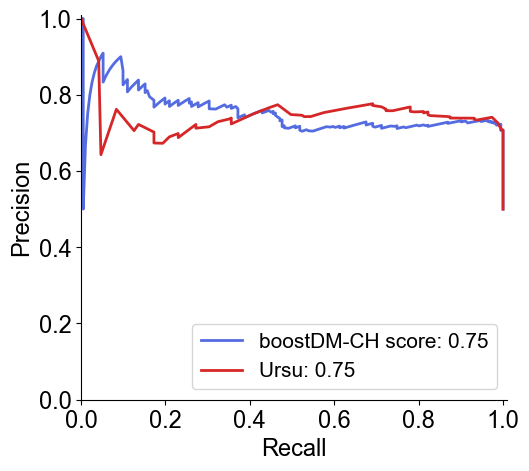

In [9]:
import matplotlib as mpl

def config_params(font_size=17):
    mpl.rcParams.update(mpl.rcParamsDefault)
    plt.rcParams['font.sans-serif'] = ['arial']
    plt.rcParams['font.size'] = font_size
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['svg.fonttype'] = 'none'
    plt.rcParams['mathtext.fontset'] = 'custom'
    plt.rcParams['mathtext.cal'] = 'arial'
    plt.rcParams['mathtext.rm'] = 'arial'
    
config_params(font_size=17)
fig, ax = plt.subplots(figsize=(5.5,5))

auc_score_bdm, precision_bdm, recall_bdm, probs_bed = plot_prc(gene_crossval_harv_equal, 'boostDM_score', ax=ax, color='#556CE0', lw=2, alpha=1)
auc_score, precision, recall, probs = plot_prc(gene_crossval_harv_equal, 'Ursu', ax=ax, color='#d62728', lw=2, alpha=1)
gene_crossval_harv_equal['prob_Ursu'] = probs

plt.legend(labels=[f'boostDM-CH score: {auc_score_bdm:.2}',\
                   f'Ursu: {auc_score:.2}'], fontsize=15, loc='lower right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# plt.xticks(size=15)
# plt.yticks(size=15)
# plt.xlabel(size=15)
# plt.ylabel(size=15)

plt.show()

In [11]:
gene_crossval_harv_equal['cat_Ursu'] = gene_crossval_harv_equal['prob_Ursu'].apply(lambda x:1 if x >=0.5 else 0)
gene_crossval_harv_equal

,gene,chr,pos,alt,aachange,CLUSTL_SCORE,CLUSTL_cat_1,HotMaps_cat_1,smRegions_cat_1,PhyloP,nmd,Acetylation,Methylation,Phosphorylation,Regulatory_Site,Ubiquitination,csqn_type_missense,csqn_type_nonsense,csqn_type_splicing,csqn_type_synonymous,ref,driver,boostDM_score,iteration,boostDM_predic,row,ID,Ursu,Ursu_cat_pap,Ursu_cat_paper,prob_Ursu,cat_Ursu
0,TP53,17,7674221,A,R248W,0.0000,0,1,1,0.834961,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.747464,0,1,23,7674221A,289.806537,Impactful II,1,0.764400,1
1,TP53,17,7673803,A,R273C,513.7234,1,1,1,5.730469,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,G,1.0,0.633640,0,1,65,7673803A,241.672937,Impactful I,1,0.624276,1
2,TP53,17,7674229,T,G245D,0.0000,0,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,1.0,0.804838,0,1,5,7674229T,377.474615,Impactful II,1,0.916510,1
3,TP53,17,7673802,T,R273H,513.7234,1,1,1,7.906250,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.878231,0,1,14,7673802T,169.301582,Impactful I,1,0.377900,0
4,TP53,17,7675153,C,P153P,0.0000,0,0,0,-4.945312,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,G,0.0,0.018101,0,0,21,7675153C,26.963053,WT-like,0,0.077454,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,TP53,17,7674872,C,Y220C,0.0000,0,1,1,6.253906,0,0.0,0.0,1.0,0.0,0.0,1,0,0,0,T,0.0,0.933222,49,1,5541,7674872C,209.854551,Impactful II,1,0.516332,1
378,TP53,17,7676228,T,P47P,0.0000,0,0,0,-1.582031,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,C,0.0,0.026500,49,0,5568,7676228T,30.225285,WT-like,0,0.080757,0
379,TP53,17,7676261,T,P36P,0.0000,0,0,0,-1.120117,0,0.0,0.0,0.0,0.0,0.0,0,0,0,1,C,0.0,0.023000,49,0,5597,7676261T,29.115262,WT-like,0,0.079619,0
380,TP53,17,7675088,T,R175H,0.0000,0,1,1,6.164062,0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,C,0.0,0.903819,49,1,5599,7675088T,365.212625,Impactful II,1,0.902504,1


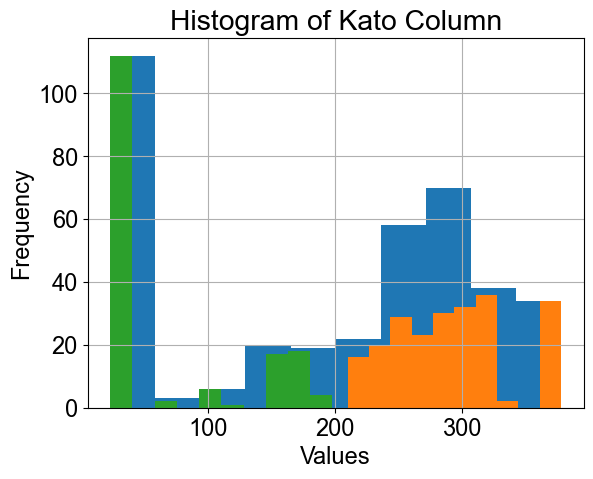

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming gene_crossval_harv_equal is your DataFrame

# Plot the histogram for the 'Kato' column
gene_crossval_harv_equal['Ursu'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Ursu']==1]['Ursu'].hist()
gene_crossval_harv_equal[gene_crossval_harv_equal['cat_Ursu']==0]['Ursu'].hist()


# Add labels and title to the plot (optional)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Histogram of Kato Column')

# Display the plot
plt.show()

In [13]:
# Where does the limit been stablished
gene_crossval_harv_equal[gene_crossval_harv_equal['prob_Ursu']<0.5]['Ursu'].max()

198.0093627

# 4. F50 score and performance

In [14]:
### Define classification metric scores

def get_mcc(tp, tn, fp, fn):
    
    try:
        return (tp*tn - fp*fn) / np.sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
    except:
        return None

def get_acc(tp, tn, fp, fn):
    
    try:
        return (tp+tn) / (tp+tn+fp+fn)
    except:
        return None


def get_precision(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fp)
    except:
        return None

    
def get_recall(tp, tn, fp, fn):
    
    try:
        return tp / (tp + fn)
    except:
        return None

    
def get_npv(tp, tn, fp, fn):
    
    try:
        return tn / (tn + fn)
    except:
        return None


def get_f1(tp, tn, fp, fn):
    
    try:
        return tp / (tp + 0.5 * (fp + fn))
    except:
        return None


def get_fbeta(tp, tn, fp, fn, beta=0.5):
    
    """
    beta is chosen such that recall is considered 
    beta times as important as precision
    """
    
    p = 1 + beta ** 2
    
    try:
        return (p * tp) / ((p * tp) + (p - 1) * fn + fp)
    except:
        return None

In [15]:
### Define function to calculate specific statistic

def quality_statistic(data, method, statistic='Fscore50'):

    ## Define tp, tn, fp, fn
    tp = len(data[(data['driver']==1) & (data[method]==1)])
    tn = len(data[(data['driver']==0) & (data[method]==0)])
    fp = len(data[(data['driver']==0) & (data[method]==1)])
    fn = len(data[(data['driver']==1) & (data[method]==0)])

    ## Calculate quality statistics
    if statistic=='Fscore50':
        return get_fbeta(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='Accuracy':
        return get_acc(tp, tn, fp, fn)
    if statistic=='Precision':
        return get_precision(tp, tn, fp, fn)
    if statistic=='Recall':
        return get_recall(tp, tn, fp, fn)
    if statistic=='F1':
        return get_f1(tp, tn, fp, fn)
    if statistic=='MCC':
        return get_mcc(tp, tn, fp, fn)
    if statistic=='NPV':
        return get_npv(tp, tn, fp, fn)

In [16]:
#Analysis

eval_boostdm = []
eval_Ursu = []
eval_Ursu_paper = []
suma = []
#make same random
for i in range(0,50):
    gene_crossval_harv_i = gene_crossval_harv_equal[gene_crossval_harv_equal['iteration']==i]
    driv1 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==1]
    driv0 = gene_crossval_harv_i[gene_crossval_harv_i['driver']==0]
    if len(driv1) > len(driv0):
        driv1 = driv1.sample(n=len(driv0), random_state=42)
    elif len(driv1) < len(driv0):
        driv0 = driv0.sample(n=len(driv1), random_state=42)
    gene_crossval_harv_equal_i = pd.concat([driv1, driv0])
    suma.append(len(gene_crossval_harv_equal_i))
    
    
    ## Calculate all statistics for each method
    for method in ['boostDM_predic', 'cat_Ursu', 'Ursu_cat_paper']:
        statistics = []
        for statistic in ['Fscore50', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']: 
            # Calculate statistic
            statistics.append(quality_statistic(gene_crossval_harv_equal_i, method=method, statistic=statistic))
        if method == 'boostDM_predic': eval_boostdm.append(statistics)
        elif method == 'cat_Ursu': eval_Ursu.append(statistics)
        elif method == 'Ursu_cat_paper': eval_Ursu_paper.append(statistics)
sum(suma)

382

In [18]:
### Create summary dataframe with means

results_dataframe_12 = pd.DataFrame({'Statistic': pd.Series(['$F_{50}$', 'F1', 'Accuracy', 'Precision', 'Recall', 'NPV']),
                'BoostDM': pd.DataFrame(eval_boostdm).mean(),
                'Ursu': pd.DataFrame(eval_Ursu).mean(),
                'Ursu_paper': pd.DataFrame(eval_Ursu_paper).mean(),
                'BoostDM_Q1': pd.DataFrame(eval_boostdm).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'BoostDM_Q3': pd.DataFrame(eval_boostdm).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Ursu_Q1': pd.DataFrame(eval_Ursu).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Ursu_Q3': pd.DataFrame(eval_Ursu).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Ursu_paper_Q1': pd.DataFrame(eval_Ursu_paper).quantile(q=[0.25], axis=0, numeric_only=True).reset_index(drop=True).iloc[0],
                'Ursu_paper_Q3': pd.DataFrame(eval_Ursu_paper).quantile(q=[0.75], axis=0, numeric_only=True).reset_index(drop=True).iloc[0]})
results_dataframe_12

,Statistic,BoostDM,Ursu,Ursu_paper,BoostDM_Q1,BoostDM_Q3,Ursu_Q1,Ursu_Q3,Ursu_paper_Q1,Ursu_paper_Q3
0,$F_{50}$,0.792721,0.778222,0.781247,0.675676,0.860837,0.689655,0.906177,0.693277,0.833333
1,F1,0.847059,0.801687,0.845316,0.769231,0.904040,0.732955,0.904040,0.771368,0.888889
2,Accuracy,0.813167,0.798452,0.803810,0.700000,0.893750,0.700000,0.893750,0.723214,0.875000
3,Precision,0.762286,0.783066,0.745608,0.635417,0.851190,0.666667,1.000000,0.643939,0.800000
4,Recall,0.973810,0.862238,0.996667,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000
5,NPV,0.971574,0.872976,0.995918,1.000000,1.000000,0.750000,1.000000,1.000000,1.000000


In [19]:
plot_data = results_dataframe_12.iloc[[0, 3, 4],0:3].reset_index(drop=True)
error_data = results_dataframe_12.iloc[[0, 3, 4],].reset_index(drop=True)
plot_data

,Statistic,BoostDM,Ursu
0,$F_{50}$,0.792721,0.778222
1,Precision,0.762286,0.783066
2,Recall,0.973810,0.862238


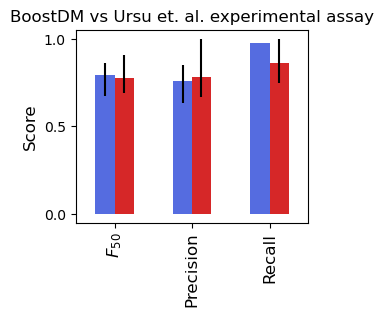

In [20]:
mpl.style.use('default')
plot_data[plot_data['Statistic'].isin([r"$F_{50}$", 'Precision', 'Recall'])].plot.bar(x='Statistic',\
                                                                                      figsize=(3,2.5),\
                                                                                      color=['#556CE0', '#d62728', '#304D30'])

#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.BoostDM-row.BoostDM_Q1], [row.BoostDM_Q3-row.BoostDM]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx-0.12,row.BoostDM, yerr=ci, fmt=' ', ecolor = 'k')
#Add error bar BoostDM
for idx, row in error_data.iloc[::-1].iterrows():
    ci = [[row.Ursu-row.Ursu_Q1], [row.Ursu_Q3-row.Ursu]]
    if ci[0][0] > 0 and ci[1][0] >0:
        plt.errorbar(idx+0.12,row.Ursu, yerr=ci, fmt=' ', ecolor = 'k')#Add error bar BoostDM

plt.title('BoostDM vs Ursu et. al. experimental assay', size=12)
plt.ylabel('Score', size=12)
plt.xticks(size=12)
plt.xlabel('')
# plt.yticks(np.arange(0, 1, 0.5))
# plt.ylim(-0.1, 1.1)
plt.xticks(np.arange(3), [r"$F_{50}$", 'Precision', 'Recall'], size=12)
plt.yticks(np.arange(0, 2, 0.5))
plt.ylim(-0.05, 1.05)
plt.legend().remove()
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=9)
plt.show()

In [21]:
len(set(gene_crossval_harv_equal.aachange))

74

In [22]:
len(set(gene_crossval_harv.aachange))

75